In [37]:
import os
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)

from transformers import SamModel


In [38]:
TRAIN_DIR = "/content/drive/MyDrive/IT-geo/domain_shift/train"
TEST_DIR  = "/content/drive/MyDrive/IT-geo/domain_shift/test"


In [39]:
class NPYSemanticDataset(Dataset):
    def __init__(self, root_dir):
        self.samples = []
        self.labels = []

        for label, cls in enumerate(["real_river", "rusels"]):
            cls_dir = os.path.join(root_dir, cls)
            for fname in os.listdir(cls_dir):
                if fname.endswith(".npy"):
                    self.samples.append(os.path.join(cls_dir, fname))
                    self.labels.append(label)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x = np.load(self.samples[idx])  # (512,512,3)
        x = torch.from_numpy(x).float().permute(2, 0, 1)  # (3,H,W)
        y = self.labels[idx]
        return x, y


In [40]:
device = "cuda" if torch.cuda.is_available() else "cpu"


In [41]:
from transformers import SamModel
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

sam = SamModel.from_pretrained("facebook/sam-vit-base")
sam.eval().to(device)

for p in sam.parameters():
    p.requires_grad = False

vision_encoder = sam.vision_encoder   # ВОТ ОН


In [42]:
def extract_embeddings(dataloader, vision_encoder):
    feats, labels = [], []

    with torch.no_grad():
        for x, y in tqdm(dataloader):
            x = x.to(device)

            # апскейл под SAM
            if x.shape[-1] != 1024:
                x = F.interpolate(
                    x,
                    size=(1024, 1024),
                    mode="bilinear",
                    align_corners=False
                )

            out = vision_encoder(pixel_values=x)

            feat_map = out.last_hidden_state  # (B, 256, H', W')
            emb = feat_map.mean(dim=[2, 3])   # GAP → (B, 256)

            feats.append(emb.cpu().numpy())
            labels.append(y.numpy())

    return np.vstack(feats), np.hstack(labels)


In [43]:
train_ds = NPYSemanticDataset(TRAIN_DIR)
test_ds  = NPYSemanticDataset(TEST_DIR)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=4, shuffle=False)


In [44]:
X_train, y_train = extract_embeddings(train_loader, vision_encoder)
X_test,  y_test  = extract_embeddings(test_loader,  vision_encoder)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


100%|██████████| 11/11 [18:00<00:00, 98.23s/it]

Train shape: (130, 256)
Test shape: (42, 256)


In [45]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        n_jobs=-1
    ))
])

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:, 1]


In [46]:
print("=== RAW EMBEDDINGS ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

pr, rc, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")
print(f"Precision: {pr:.3f}, Recall: {rc:.3f}, F1: {f1:.3f}")

print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=["river", "rusels"]))


=== RAW EMBEDDINGS ===
Accuracy: 0.8809523809523809
ROC AUC: 0.9886621315192743
Precision: 1.000, Recall: 0.762, F1: 0.865

Confusion matrix:
[[21  0]
 [ 5 16]]

Classification report:
              precision    recall  f1-score   support

       river       0.81      1.00      0.89        21
      rusels       1.00      0.76      0.86        21

    accuracy                           0.88        42
   macro avg       0.90      0.88      0.88        42
weighted avg       0.90      0.88      0.88        42



In [47]:
pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca  = pca.transform(X_test)

print("Explained variance:", pca.explained_variance_ratio_.sum())


Explained variance: 0.8176248


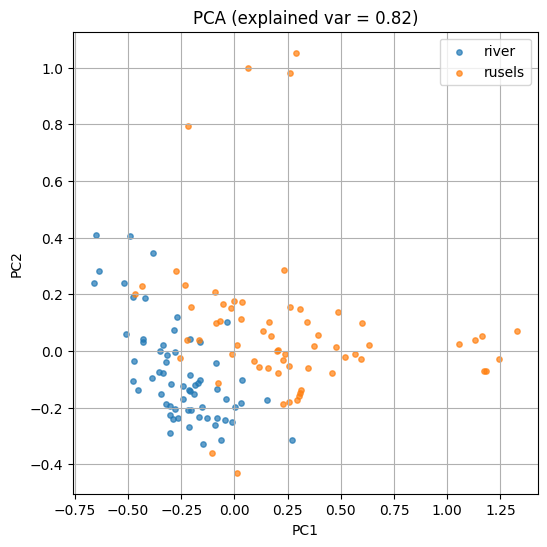

In [48]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

domain_names = np.array(["river", "rusels"])

plt.figure(figsize=(6, 6))
for cls in [0, 1]:
    idx = y_train == cls
    plt.scatter(
        X_train_pca[idx, 0],
        X_train_pca[idx, 1],
        s=15,
        alpha=0.7,
        label=domain_names[cls]
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"PCA (explained var = {pca.explained_variance_ratio_[:2].sum():.2f})")
plt.legend()
plt.grid(True)
plt.show()
